In [19]:
import sqlite3
import pandas as pd

Hello! For Aneeza, Caegs, Rae, and Raymond, this is to combine all of the datafiles into one database. We have two tables in ```fires.db```.

# Filtering Down the US-Wildfires

The columns that we are going to use are:
* FOD_ID
    * Global unique identifier.
* DISCOVERY_DATE 
    * Date on which the fire was discovered or confirmed to exist. Note that this is in the Julian calendar.
* DISCOVERY_TIME
    * Time of day that the fire was discovered or confirmed to exist.
* CONT_DOY
    * Day of year on which the fire was declared contained or otherwise controlled. Note that this is in the Julian calendar.
* CONT_TIME
    * Time of day that the fire was declared contained or otherwise controlled (hhmm where hh=hour, mm=minutes).
* FIRE_SIZE
    * Estimate of acres within the final perimeter of the fire.
* STATE
    * Two-letter alphabetic code for the state in which the fire burned (or originated), based on the nominal designation in the fire report.



In [3]:
# Connect to the US Wildfires database
db_path = '/mnt/data/public/us-wildfires/FPA_FOD_20170508.sqlite'
conn = sqlite3.connect(db_path)

query = """
SELECT FOD_ID, DISCOVERY_DATE, DISCOVERY_TIME, CONT_DATE, CONT_TIME, FIRE_SIZE, STATE
FROM Fires
"""

us_fires = pd.read_sql(query, conn)
us_fires.head()


,FOD_ID,DISCOVERY_DATE,DISCOVERY_TIME,CONT_DATE,CONT_TIME,FIRE_SIZE,STATE
0,1,2453403.5,1300,2453403.5,1730,0.10,CA
1,2,2453137.5,0845,2453137.5,1530,0.25,CA
2,3,2453156.5,1921,2453156.5,2024,0.10,CA
3,4,2453184.5,1600,2453189.5,1400,0.10,CA
4,5,2453184.5,1600,2453189.5,1200,0.10,CA


# Filtering Down the London Fire Brigade

For the London Fire Brigade, there is the Incident data and the Mobilisation data. For the Incident data, we will be looking at the columns:
* IncidentNumber
* DateOfCall
* IncidentGroup	
* StopCodeDescription	
* SpecialServiceType
* Notional Cost (£)


In [5]:
# Loading Incident Data Files

# We will get only from 2009 to 2022
incident_2009_2022 = '/mnt/data/public/lfb/LFB Incident data - Datastore - with notional cost and UPRN from January 2009.csv'
incident_2009_2022 = pd.read_csv(incident_2009_2022, dtype={"235138081": str})
features = ['235138081', '01 Jan 2009', 'Special Service', 'Special Service.1', 'RTC', '255']
incident_2009_2022 = incident_2009_2022[features]
incident_2009_2022.columns = ['IncidentNumber', 'DateOfCall', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'Notional Cost (£)']

# Get only dates from 2023
incident_2020_2023 = '/mnt/data/public/lfb/LFB Incident data from January 2020 to August 2023.xlsx'
incident_2020_2023 = pd.read_excel(incident_2020_2023, usecols=['IncidentNumber', 'DateOfCall', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'Notional Cost (£)'])

Further filter out data, and combine the two dataframes into one big dataframe.

In [7]:
# Create a new dataframe from incident_2020_2023 where it only has Fires from 2023
filt_year = incident_2020_2023['DateOfCall'].dt.year == 2023
incident_2023 = incident_2020_2023[filt_year]
all_incidents = pd.concat([incident_2009_2022, incident_2023])

# Convert DateOfCall to proper timestamp
all_incidents["DateOfCall"] = pd.to_datetime(all_incidents["DateOfCall"], format="%d %b %Y")

all_incidents.head()

,IncidentNumber,DateOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,Notional Cost (£)
0,1091,2009-01-01,Special Service,Special Service,Assist other agencies,NaN
1,2091,2009-01-01,Fire,Secondary Fire,NaN,255.0
2,3091,2009-01-01,Fire,Secondary Fire,NaN,255.0
3,5091,2009-01-01,Fire,Secondary Fire,NaN,255.0
4,6091,2009-01-01,False Alarm,AFA,NaN,255.0


For the Mobilisation data, we will be looking at the columns:
* IncidentNumber
* DateAndTimeMobilised	
* DateAndTimeMobile	
* DateAndTimeArrived	
* DateAndTimeLeft
* DelayCode_Description

In [8]:
# Loading Mobilisation Data Files
all_mobilisation = '/mnt/data/public/lfb/mobilisation/LFB Mobilisation data from January 2009 to August 2023.csv'
all_mobilisation = pd.read_csv(all_mobilisation, dtype={"235138081": str, '01/01/2009 00:23:55':str})

# Cleaning the files
features = [all_mobilisation.columns[i] for i in [0, 6, 7, 8, 12, 21]]
all_mobilisation = all_mobilisation[features]
all_mobilisation.columns = ['IncidentNumber', 'DateAndTimeMobilised', 'DateAndTimeMobile', 'DateAndTimeArrived', 'DateAndTimeLeft', 'DelayCode_Description']

# Converting the datetime columns into an actual datetime format
datetime_columns = ["DateAndTimeMobilised", "DateAndTimeMobile", "DateAndTimeArrived", "DateAndTimeLeft"]
all_mobilisation[datetime_columns] = all_mobilisation[datetime_columns].apply(
    pd.to_datetime, format="%d/%m/%Y %H:%M:%S", errors="coerce")

We will now join the ```london_incidents``` and ```london_mobilisation``` using the key-id of IncidentNumber.

In [10]:
all_mobilisation.head()

,IncidentNumber,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,DateAndTimeLeft,DelayCode_Description
0,235138081,2009-01-01 00:02:27,2009-01-01 00:06:40,2009-01-01 00:08:09,2009-01-01 00:12:17,NaN
1,2091,2009-01-01 00:04:09,2009-01-01 00:06:40,2009-01-01 00:09:17,2009-01-01 00:16:33,NaN
2,3091,2009-01-01 00:04:57,2009-01-01 00:06:45,2009-01-01 00:08:27,2009-01-01 00:20:38,NaN
3,5091,2009-01-01 00:06:04,2009-01-01 00:07:58,2009-01-01 00:09:57,2009-01-01 00:11:58,NaN
4,5091,2009-01-01 00:06:04,2009-01-01 00:08:26,2009-01-01 00:10:14,NaT,NaN


In [11]:
london_fires = pd.merge(all_incidents, all_mobilisation, on="IncidentNumber", how="inner")
london_fires.head()

,IncidentNumber,DateOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,Notional Cost (£),DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,DateAndTimeLeft,DelayCode_Description
0,2091,2009-01-01,Fire,Secondary Fire,NaN,255.0,2009-01-01 00:04:09,2009-01-01 00:06:40,2009-01-01 00:09:17,2009-01-01 00:16:33,NaN
1,3091,2009-01-01,Fire,Secondary Fire,NaN,255.0,2009-01-01 00:04:57,2009-01-01 00:06:45,2009-01-01 00:08:27,2009-01-01 00:20:38,NaN
2,5091,2009-01-01,Fire,Secondary Fire,NaN,255.0,2009-01-01 00:06:04,2009-01-01 00:07:58,2009-01-01 00:09:57,2009-01-01 00:11:58,NaN
3,5091,2009-01-01,Fire,Secondary Fire,NaN,255.0,2009-01-01 00:06:04,2009-01-01 00:08:26,2009-01-01 00:10:14,NaT,NaN
4,6091,2009-01-01,False Alarm,AFA,NaN,255.0,2009-01-01 00:06:30,2009-01-01 00:07:53,2009-01-01 00:09:22,2009-01-01 00:15:57,NaN


In [14]:
filt = london_fires['IncidentGroup'] == 'Fire'
london_fires = london_fires[filt]

In [25]:
london_fires['LENGTH_CONTAINED'] = london_fires['DateAndTimeLeft'] - london_fires['DateAndTimeMobilised']
london_fires["LENGTH_HOURS"] = london_fires["LENGTH_CONTAINED"].dt.total_seconds() / 3600  

In [31]:
print(london_fires['LENGTH_HOURS'].describe())

count    2.190138e+06
mean     3.917344e-01
std      4.606227e-01
min      1.111111e-03
25%      1.794444e-01
50%      2.583333e-01
75%      4.100000e-01
max      3.532167e+01
Name: LENGTH_HOURS, dtype: float64


<Axes: xlabel='Notional Cost (£)', ylabel='Count'>

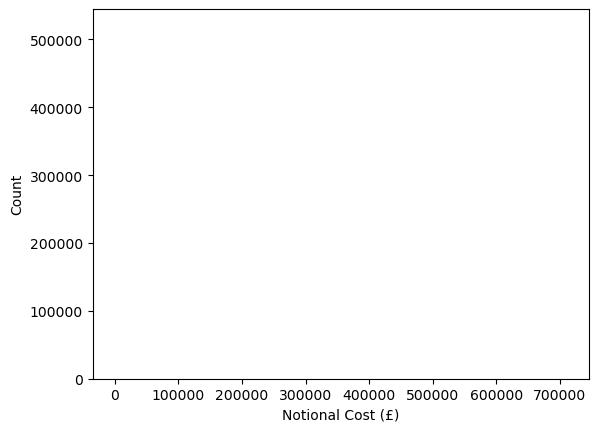

In [33]:
sns.histplot(london_fires['Notional Cost (£)'])

In [35]:
london_fires['Notional Cost (£)'].describe()

count    2.236128e+06
mean     4.813058e+02
std      2.206916e+03
min      2.550000e+02
25%      2.900000e+02
50%      3.280000e+02
75%      3.640000e+02
max      7.094640e+05
Name: Notional Cost (£), dtype: float64

In [46]:
cost = london_fires[london_fires['Notional Cost (£)'] < 600]